MIT License
Copyright (c) 2022 Wenjun Xie

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%matplotlib inline
import numpy as np
from scipy.spatial.distance import pdist,squareform
from Bio import SeqIO
import pandas as pd
import copy
import re
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns

### for plotting figures

In [2]:
def cm2inch(value):
        return value/2.54

color_m1=( 0.231, 0.467, 0.686)
color_m2=( 0.329, 0.616, 0.267)

mpl.rcParams['figure.figsize']=[cm2inch(10),cm2inch(10)]
mpl.rcParams['legend.fontsize']=6
mpl.rcParams['axes.linewidth']=0.5
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['legend.edgecolor']='black'
mpl.rcParams['font.family'] = "Arial"
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6) 

sns.set_style("ticks")

### functions used to process sequences

In [3]:
#Some functions in this block is modified from Sergey Ovchinnikov's code

alphabet = "ACDEFGHIKLMNPQRSTVWY-"      #the order of amino acids
states = len(alphabet)

a2n = {}
for a,n in zip(alphabet,range(states)):
    a2n[a] = n

def aa2num(aa):
    '''convert amino acid into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']

def fasta2mat(fasta_map):
    '''convert MSA into matrix'''
    sequence = []
    for value in fasta_map.values():
        sequence.append([aa2num(i) for i in value])
    return np.array(sequence)

def get_eff(msa, eff_cutoff=0.8):
    '''compute effective weight for each sequence'''
    ncol = msa.shape[1]
    msa_sm = 1.0 - squareform(pdist(msa,"hamming"))     #pairwise similarity
    msa_w = np.zeros_like(msa_sm)       #weight for sequence
    msa_w[np.where(msa_sm >= eff_cutoff)] = 1
    msa_w = 1/np.sum(msa_w,-1)
    return msa_w

def filt_gap(msa, gap_cutoff):
    '''remove gap sites'''
    tmp = np.zeros_like(msa)
    tmp[np.where(msa == 20)] = 1
    non_gap = np.where(np.sum(tmp,0)/tmp.shape[0] < gap_cutoff)[0]
    return msa[:,non_gap], non_gap

# 1. Processing MSA

In [4]:
#read MSA
#MSAs are constructed with AlphaFold and are provided as supporting data
fasta_map = {}
with open("./MSA/KE07_initial_designgap_lt_5.fa") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        fasta_map[record.id] = str(record.seq)
print ('number of MSA:', len(fasta_map))

#process MSA
gap_cutoff = 0.30       #used to filter gap regions
msa = fasta2mat(fasta_map)
num_seq, num_aa_msa = msa.shape
msa_filted, non_gap = filt_gap(msa,gap_cutoff)
msa_eff = get_eff(msa_filted)       #used to down-weight similar sequences
msa_filted_onehot = np.eye(states)[msa_filted]
_, num_aa_filted = msa_filted.shape
print ('number of non_gap sites:', len(non_gap))

# #calculate experimental constraints used in the parameterization of the MaxEnt model
# #frequency of single amino acid (p) and pairwise frequency (pij) are calculated and written into the same file
# msa_filted_onehot_flatten = msa_filted_onehot.reshape(num_seq,-1)
# p=np.einsum('i,ij->j', msa_eff, msa_filted_onehot_flatten)/np.einsum('i->', msa_eff)
# pij = np.einsum('j,ji,jk->ik', msa_eff, msa_filted_onehot_flatten, msa_filted_onehot_flatten)/np.einsum('i->', msa_eff)
# pij = pij.reshape(num_aa_filted, states, num_aa_filted, states)
# triu = np.triu_indices(num_aa_filted, 1)
# pij = pij[triu[0],:,triu[1],:].flatten()
# exp_new = np.concatenate((p,pij))
# np.savetxt('experimental_constraints.txt', exp_new, fmt='%8.6f')

number of MSA: 15685
number of non_gap sites: 249


# 2. Processing mutants

In [5]:
#process mutations to get input for the MaxEnt energy calculation
seq_KE07 = 'MLAKRIIAALIVKDGRVVKGSNFENLRDSGDPVELGKFYSEIGIDELSFWDITASVEKRKTMLELVEKVAEQIDIPFTVGGGIHDFETASELILRGADKVEINTAAVENPSLITQIAQTFGSQAVVVYIAAKRVDGEFMVFTYSGKKNTGILLRDWVVEVEKRGAGEIVLGSIDRLGTKSGYDTEMIRFVRPLTTLPIIAHGGAGKMEHFLEAFLAGADAAKANSVFHFREIDVRELKEYLKKHGVNVRLEGL'
seq_WT = seq_KE07

In [6]:
#KE07_DE
df = pd.read_excel('Kemp_summary.xlsx',sheet_name='KE07_DE',comment='#')

msa_mut = []
for idx, mut in enumerate(df['mutation']):
    mut_seq = list(copy.deepcopy(seq_WT))
    if idx>0: # the first is seq_KE07
        mut_split = re.split('/', mut)
        for one in mut_split:
            mut_seq[int(one[1:-1])-1] = one[-1]
    msa_mut.append([aa2num(i) for i in mut_seq])
msa_mut_non_gap = np.array(msa_mut)[:,non_gap]
np.savetxt('./msa_mut_non_gap_KE07_directed_evolution.txt', msa_mut_non_gap+1, fmt='%2i') # need to +1 to be consistent with the fortran code to calculate the MaxEnt energy

In [7]:
#Catalytic-actie remote region
df = pd.read_excel('Kemp_summary.xlsx',sheet_name='KE07_remote_region',comment='#')

msa_mut = []
for idx, mut in enumerate(df['mutation']):
    mut_seq = list(copy.deepcopy(seq_WT))
    if idx>=0: # the first is not seq_KE07
        mut_split = re.split('/', mut)
        for one in mut_split:
            mut_seq[int(one[1:-1])-1] = one[-1]
    msa_mut.append([aa2num(i) for i in mut_seq])
msa_mut_non_gap = np.array(msa_mut)[:,non_gap]
np.savetxt('./msa_mut_non_gap_KE07_remote_region.txt', msa_mut_non_gap+1, fmt='%2i') # need to +1 to be consistent with the fortran code to calculate the MaxEnt energy

# 3. Parameterize the MaxEnt model

Code and tutorials for parameterizing the MaxEnt model can be found in the software MEME (https://github.com/Wenjun-Xie/MEME).

The 'experimental_constraints.txt' in Step 1 will be the input for MEME. To accelerate the convergence, the initial parameters in MEME could use those obtained from pseudo-likelihood approximation.

The 'msa_mut_non_gap_*.txt' in Step 2 will be used to calculate the statistical energy associated with each mutant.

# 4. Evaluation (directed evolution) (figures in the main text)

### plotting E_MaxEnt-activity

In [10]:
df = pd.read_excel('./Kemp_summary.xlsx',sheet_name='KE07_DE',comment='#')
energy = np.loadtxt('./E_MaxEnt/msa_mut_energy_KE07_directed_evolution.txt')
energy = energy - energy[0]
df['dE(MaxEnt)'] = pd.Series(energy, index=df.index)
df['log(kcat)'] = np.log(df['kcat(/s)'])
df['log(kcat/Km)'] = np.log(df['kcat/Km(/s/M)'])

print (df['dE(MaxEnt)'].corr(df['log(kcat/Km)']))
print (df['dE(MaxEnt)'].corr(df['log(kcat)']))

0.8110477724058871
0.6890765625950548


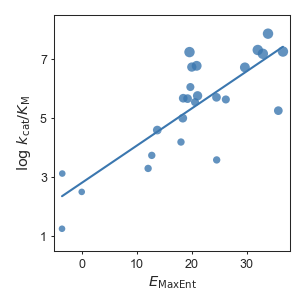

In [11]:
fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="dE(MaxEnt)", y="log(kcat/Km)", 
                   data=df,color=color_m1,label=r'$\mathrm{log}~k_{\mathrm{cat}}/K_{\mathrm{M}}$',ci=0,
                   scatter_kws={'s':10*df['round_normalized'],'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$E_{\mathrm{MaxEnt}}$',fontsize='7')
ax.set_ylabel(r'$\mathrm{log}~k_{\mathrm{cat}}/K_{\mathrm{M}}$',fontsize='7')

plot.set(xlim=(-5,38),ylim=(0.5,8.5),xticks=[0,10,20,30],yticks=[1,3,5,7])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.09,0.5)
ax.tick_params(pad=2)

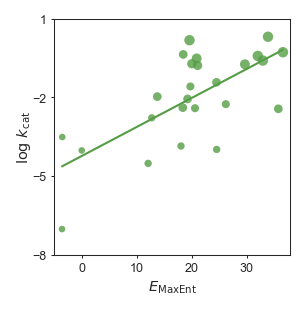

In [12]:
fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="dE(MaxEnt)", y="log(kcat)", 
                   data=df,color=color_m2,label=r'$\mathrm{log}~k_{\mathrm{cat}}$',ci=0,
                   scatter_kws={'s':10*df['round_normalized'],'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$E_{\mathrm{MaxEnt}}$',fontsize='7')
ax.set_ylabel(r'$\mathrm{log}~k_{\mathrm{cat}}$',fontsize='7')

plot.set(xlim=(-5,38),ylim=(-8,1),xticks=[0,10,20,30],yticks=[-8,-5,-2,1])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.09,0.5)
ax.tick_params(pad=2)

### plotting E_MaxEnt-stability

In [13]:
print (df['Tm (°C)'].corr(df['log(kcat/Km)']))
print (df['Tm (°C)'].corr(df['log(kcat)']))
print (df['dE(MaxEnt)'].corr(df['Tm (°C)']))
df_Tm = df[df['Tm (°C)'].notna()]

-0.7998905206716654
-0.8130350214772015
-0.7716463273983871


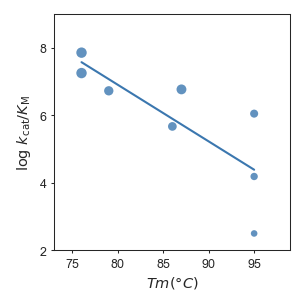

In [14]:
fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="Tm (°C)", y="log(kcat/Km)", 
                   data=df_Tm,color=color_m1,label=r'$\mathrm{log}~k_{\mathrm{cat}}/K_{\mathrm{M}}$',ci=0,
                   scatter_kws={'s':10*df_Tm['round_normalized'],'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$Tm (°C)$',fontsize='7')
ax.set_ylabel(r'$\mathrm{log}~k_{\mathrm{cat}}/K_{\mathrm{M}}$',fontsize='7')

plot.set(xlim=(73,99),ylim=(2,9),xticks=[75,80,85,90,95],yticks=[2,4,6,8])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.09,0.5)
ax.tick_params(pad=2)

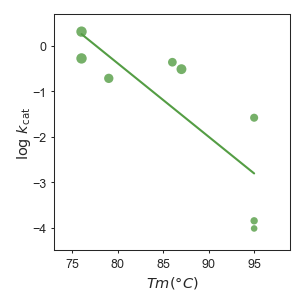

In [15]:
fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="Tm (°C)", y="log(kcat)", 
                   data=df_Tm,color=color_m2,label=r'$\mathrm{log}~k_{\mathrm{cat}}$',ci=0,
                   scatter_kws={'s':10*df_Tm['round_normalized'],'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$Tm (°C)$',fontsize='7')
ax.set_ylabel(r'$\mathrm{log}~k_{\mathrm{cat}}$',fontsize='7')

plot.set(xlim=(73,99),ylim=(-4.5,0.7),xticks=[75,80,85,90,95],yticks=[-4,-3,-2,-1,0])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.09,0.5)
ax.tick_params(pad=2)

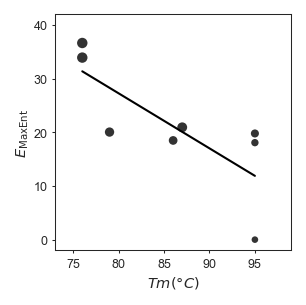

In [16]:
fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="Tm (°C)", y="dE(MaxEnt)", 
                   data=df_Tm,color='black',label=r'$Tm (°C)$',ci=0,
                   scatter_kws={'s':10*df_Tm['round_normalized'],'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$Tm (°C)$',fontsize='7')
ax.set_ylabel(r'$E_{\mathrm{MaxEnt}}$',fontsize='7')

plot.set(xlim=(73,99),ylim=(-2,42),xticks=[75,80,85,90,95],yticks=[0,10,20,30,40])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.tick_params(pad=2)

# 5. Evaluation (catalytic-active remote region) (figures in the main text)

In [17]:
df = pd.read_excel('./Kemp_summary.xlsx',sheet_name='KE07_remote_region',comment='#')
energy = np.loadtxt('./E_MaxEnt/msa_mut_energy_KE07_remote_region.txt')

energy = energy - energy[0]
df['dE(MaxEnt)'] = pd.Series(energy, index=df.index)

In [18]:
df = df[0:10] #catalytic-active
df['log(kcat)'] = np.log(df['kcat(/s)'])
df['log(kcat/Km)'] = np.log(df['kcat/Km(/s/M)'])
print (df['dE(MaxEnt)'].corr(df['log(kcat/Km)']))
print (df['dE(MaxEnt)'].corr(df['log(kcat)']))

-0.8837941369373693
-0.8948252218909513


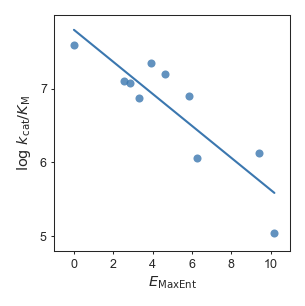

In [19]:
sns.set_style("ticks")

fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="dE(MaxEnt)", y="log(kcat/Km)", 
                   data=df,color=color_m1,label=r'$\mathrm{log}~k_{\mathrm{cat}}/K_{\mathrm{M}}$',ci=0,
                   scatter_kws={'s':15,'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$E_{\mathrm{MaxEnt}}$',fontsize='7')
ax.set_ylabel(r'$\mathrm{log}~k_{\mathrm{cat}}/K_{\mathrm{M}}$',fontsize='7')

plot.set(xlim=(-1,11),ylim=(4.8,8),xticks=[0,2,4,6,8,10],yticks=[5,6,7])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.09,0.5)
ax.tick_params(pad=2)

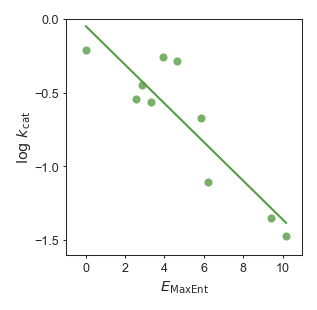

In [20]:
sns.set_style("ticks")

fig=plt.figure(0)
ax = fig.add_axes([0.16,0.16,0.4,0.4])

plot = sns.regplot(x="dE(MaxEnt)", y="log(kcat)", 
                   data=df,color=color_m2,label=r'$\mathrm{log}~k_{\mathrm{cat}}$',ci=0,
                   scatter_kws={'s':15,'edgecolors':None,'linewidths':0},
                   line_kws={'linewidth':1})
ax.grid(False)
ax.set_xlabel(r'$E_{\mathrm{MaxEnt}}$',fontsize='7')
ax.set_ylabel(r'$\mathrm{log}~k_{\mathrm{cat}}$',fontsize='7')

plot.set(xlim=(-1,11),ylim=(-1.6,0),xticks=[0,2,4,6,8,10],yticks=[-1.5,-1,-0.5,0])

ax.minorticks_off()
ax.tick_params(which='major',length=1.5,width=0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.yaxis.set_label_coords(-0.14,0.5)
ax.tick_params(pad=2)